# Time evolution for multiple spins
-----------------------------------------------------------

## To accompany "Simulating spins dynamics with quantum computers"

#### J. L. Lancaster and D. B. Allen
#### High Point University

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from qiskit import *
%matplotlib inline

Here we use the machinery developed in the single-spin case to perform time evolution on a system of multiple spins. One additional feature we will need is the gate $\hat{N}(\alpha,\beta,\gamma) = \exp\left[i\left(\alpha \sigma^{x}\otimes\sigma^{x} + \beta\sigma^{y}\otimes\sigma^{y} + \gamma\sigma^{z}\otimes\sigma^{z}\right)\right]$ discussed in the main text. 

This notebook is set up to run all circuits on the QASM simulator, which only requires either (a) a local installation of Qiskit or (b) uploading this notebook to the IBM quantum lab. To run these circuits on quantum devices, uncomment and execute the following cell:

In [ ]:
#IBMQ.load_account('paste-your-API-here')
#provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

Additionally, replace

```job = execute(timecirc,
              backend=BasicAer.get_backend('qasm_simulator'),shots=Nshots,
              parameter_binds=[{tau: t_val} for t_val in tau_range])```

by 

```qcomp = provider.get_backend('select_quantum_device_here')
job = execute(timecirc, backend=qcomp,shots=Nshots,parameter_binds=[{tau: t_val} for t_val in tau_range])
from qiskit.tools.monitor import job_monitor
job_monitor(job)```

Make sure to select an appropriate device (e.g., ```ibmq_lima```). We can define a function corresponding to the $\hat{N}(\alpha,\beta,\gamma)$ gate as follows.

In [3]:
#two-gate operator for exp[i(α σx σx + β σy σy + γ σz σz)]
def N(α,β,γ,circ,q1,q2):
    circ.rz(-0.5*np.pi,q2)
    circ.cnot(q2,q1)
    circ.rz(0.5*np.pi-2*γ,q1)
    circ.ry(2.0*α-0.5*np.pi,q2)
    circ.cnot(q1,q2)
    circ.ry(0.5*np.pi-2.0*β,q2)
    circ.cnot(q2,q1)
    circ.rz(0.5*np.pi,q1)

### Two spins (Fig. 6)

Below we define a circuit performing the computation whose results are depicted in Fig. 6. For simplicity, we split the total task into three total circuits. Each circuit will measure one component of each spin. First, the circuit for measuring $\langle \hat{S}^{z}(t)\rangle$ is

In [5]:
from qiskit.circuit import Parameter
tau = Parameter('τ')
Nt = 75
tau_range = np.linspace(0,10,Nt)

Jx = 0.5
Jy = -0.45
Jz = 0.25

qr = QuantumRegister(2)
cr = ClassicalRegister(2)

timecirc = QuantumCircuit(qr,cr) 

#initial states from text
timecirc.u(np.pi/6,np.pi/3,0,0)
timecirc.u(3*np.pi/5,4*np.pi/3,0,1)


N(Jx*tau/4.0,Jy*tau/4.0,Jz*tau/4.0,timecirc,0,1)
    
timecirc.measure(qr,[1,0])
timecirc.draw()

┌──────────────┐             ┌───┐┌───────────────────────────────┐     »
q1_0: ─┤ U(π/6,π/3,0) ├─────────────┤ X ├┤ Rz(1.5707963267949 - 0.125*τ) ├──■──»
      ┌┴──────────────┴┐┌──────────┐└─┬─┘└┬──────────────────────────────┤┌─┴─┐»
q1_1: ┤ U(3π/5,4π/3,0) ├┤ Rz(-π/2) ├──■───┤ Ry(0.25*τ - 1.5707963267949) ├┤ X ├»
      └────────────────┘└──────────┘      └──────────────────────────────┘└───┘»
c1: 2/═════════════════════════════════════════════════════════════════════════»
                                                                               »
«                                       ┌───┐┌─────────┐┌─┐
«q1_0: ─────────────────────────────────┤ X ├┤ Rz(π/2) ├┤M├
«      ┌───────────────────────────────┐└─┬─┘└───┬─┬───┘└╥┘
«q1_1: ┤ Ry(0.225*τ + 1.5707963267949) ├──■──────┤M├─────╫─
«      └───────────────────────────────┘         └╥┘     ║ 
«c1: 2/═══════════════════════════════════════════╩══════╩═
«                                                 0      1

In [6]:
Nshots = 8192

job = execute(timecirc,
              backend=BasicAer.get_backend('qasm_simulator'),shots=Nshots,
              parameter_binds=[{tau: t_val} for t_val in tau_range])

simcountsz = job.result().get_counts()

Then this circuit is duplicated with additional rotations before measurement to probe $\langle \hat{S}^{x}\rangle$ and $\langle \hat{S}^{y}\rangle$:

In [9]:
################################
# circuit to measure <Sx> ######
################################

qr = QuantumRegister(2)
cr = ClassicalRegister(2)

timecirc = QuantumCircuit(qr,cr) 

#initial states
timecirc.u(np.pi/6,np.pi/3,0,0)
timecirc.u(3*np.pi/5,4*np.pi/3,0,1)

N(Jx*tau/4.0,Jy*tau/4.0,Jz*tau/4.0,timecirc,0,1)
    
timecirc.ry(-np.pi/2,qr)    
timecirc.measure(qr,[1,0])
timecirc.draw()

Nshots = 8192

job = execute(timecirc,
              backend=BasicAer.get_backend('qasm_simulator'),shots=Nshots,
              parameter_binds=[{tau: t_val} for t_val in tau_range])

simcountsx = job.result().get_counts()


################################
# circuit to measure <Sy> ######
################################

qr = QuantumRegister(2)
cr = ClassicalRegister(2)

timecirc = QuantumCircuit(qr,cr) 

#initial states
timecirc.u(np.pi/6,np.pi/3,0,0)
timecirc.u(3*np.pi/5,4*np.pi/3,0,1)

N(Jx*tau/4.0,Jy*tau/4.0,Jz*tau/4.0,timecirc,0,1)

timecirc.rz(-np.pi/2,qr) 
timecirc.ry(-np.pi/2,qr)    
timecirc.measure(qr,[1,0])
timecirc.draw()

Nshots = 8192

job = execute(timecirc,
              backend=BasicAer.get_backend('qasm_simulator'),shots=Nshots,
              parameter_binds=[{tau: t_val} for t_val in tau_range])

simcountsy = job.result().get_counts()

Then we run through the standard post-processing:

In [10]:
c00 = np.array(list(map(lambda c: c.get('00', 0), simcountsx)))
c01 = np.array(list(map(lambda c: c.get('01', 0), simcountsx)))
c10 = np.array(list(map(lambda c: c.get('10', 0), simcountsx)))
c11 = np.array(list(map(lambda c: c.get('11', 0), simcountsx)))

Sx1 = 0.5*(c00+c01-c10-c11)/Nshots
Sx2 = 0.5*(c00+c10-c01-c11)/Nshots

c00 = np.array(list(map(lambda c: c.get('00', 0), simcountsy)))
c01 = np.array(list(map(lambda c: c.get('01', 0), simcountsy)))
c10 = np.array(list(map(lambda c: c.get('10', 0), simcountsy)))
c11 = np.array(list(map(lambda c: c.get('11', 0), simcountsy)))

Sy1 = 0.5*(c00+c01-c10-c11)/Nshots
Sy2 = 0.5*(c00+c10-c01-c11)/Nshots

c00 = np.array(list(map(lambda c: c.get('00', 0), simcountsz)))
c01 = np.array(list(map(lambda c: c.get('01', 0), simcountsz)))
c10 = np.array(list(map(lambda c: c.get('10', 0), simcountsz)))
c11 = np.array(list(map(lambda c: c.get('11', 0), simcountsz)))

Sz1 = 0.5*(c00+c01-c10-c11)/Nshots
Sz2 = 0.5*(c00+c10-c01-c11)/Nshots

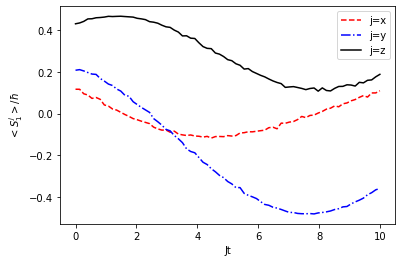

In [27]:
plt.plot(tau_range,Sx1,'r--')
plt.plot(tau_range,Sy1,'b-.')
plt.plot(tau_range,Sz1,'k-')
plt.xlabel('Jt')
plt.ylabel('$<S_{1}^{j}>/\hbar$')
plt.legend(['j=x','j=y','j=z'])
plt.show()

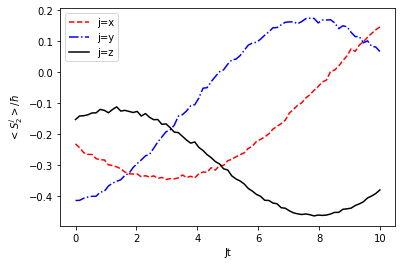

In [28]:
plt.plot(tau_range,Sx2,'r--')
plt.plot(tau_range,Sy2,'b-.')
plt.plot(tau_range,Sz2,'k-')
plt.xlabel('Jt')
plt.ylabel('$<S_{2}^{j}>/\hbar$')
plt.legend(['j=x','j=y','j=z'])
plt.show()

### Three spins (Fig. 7)

For the case of more than two spins, Lie-Trotter decomposition is necessary to approximate the time evolution operator. For simplicity, we only extract the spin project along the $\hat{z}$ axis. Other components are obtained straightforwardly by performing appropriate rotations to the qubits just before measurement.

In [30]:
from qiskit.circuit import Parameter
tau = Parameter('τ')
Nt = 75
tau_range = np.linspace(0,10,Nt)

Jx = 0.5
Jy = -0.45
Jz = 0.25

ntrot = 100

qr = QuantumRegister(3)
cr = ClassicalRegister(3)

timecirc = QuantumCircuit(qr,cr) 

#initial states
timecirc.u(np.pi/6,np.pi/3,0,0)
timecirc.u(3*np.pi/5,4*np.pi/3,0,1)
timecirc.u(-np.pi/5,2*np.pi/3,0,2)

for i in range(0,ntrot):
    N(Jx*(tau/ntrot)/4.0,Jy*(tau/ntrot)/4.0,Jz*(tau/ntrot)/4.0,timecirc,0,1)
    N(Jx*(tau/ntrot)/4.0,Jy*(tau/ntrot)/4.0,Jz*(tau/ntrot)/4.0,timecirc,1,2)
    
timecirc.measure(qr,cr)
timecirc.draw()

Nshots = 8192

job = execute(timecirc, backend=BasicAer.get_backend('qasm_simulator'),shots=Nshots,parameter_binds=[{tau: t_val} for t_val in tau_range])

simcounts = job.result().get_counts()

In [31]:
#array to store time-dependent expectation values for all three spins

Szt = np.zeros((3,Nt))

for i in range(0,Nt):
    counts = simcounts[i]
    keylist = list(counts.keys())
    for j in range(0,len(keylist)):
        state = keylist[j]
        
        if (state[0]=='0'):
            Szt[0,i] = Szt[0,i] + counts[state]
        else:
            Szt[0,i] = Szt[0,i] - counts[state]
            
            
        if (state[1]=='0'):
            Szt[1,i] = Szt[1,i] + counts[state]
        else:
            Szt[1,i] = Szt[1,i] - counts[state]
            
            
        if (state[2]=='0'):
            Szt[2,i] = Szt[2,i] + counts[state]
        else:
            Szt[2,i] = Szt[2,i] - counts[state]
        
Szt = 0.5*Szt/Nshots    

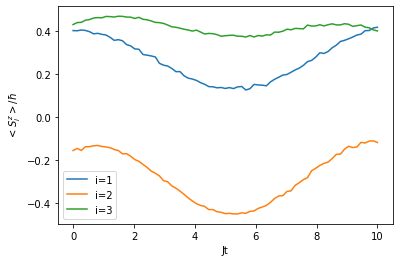

In [32]:
plt.plot(tau_range,Szt[0,:])
plt.plot(tau_range,Szt[1,:])
plt.plot(tau_range,Szt[2,:])
plt.xlabel('Jt')
plt.ylabel('$<S_{i}^{z}>/\hbar$')
plt.legend(['i=1','i=2','i=3'])
plt.show()

In practice, the three-spin system is quite difficult simulate accurately. Anecdotally, we were only able to obtain passable results using ```ibm_perth```, a seven-qubit device available in the IBM Quantum Researchers program. 